# HW6: Variational Autoencoders


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Spring, 2021._

---

**Name:** Jake Taylor

**Names of any collaborators:** Spencer Braun, Lauren Pendo

*Due: 11:59pm Monday, May 17, 2021 via GradeScope*

---

Our goal is to learn the parameters $\Theta$ of a distribution over data, $p(x_n \mid \Theta)$. We assume a latent variable model of the following form:
$$
p(x_n \mid \Theta) = \int p(x_n \mid z_n, \Theta) \, p(z_n) \mathrm{d} z_n
$$
The prior $p(z_n)$ can be very simple (e.g. a standard Gaussian distribution) as long as the likelihood, $p(x_n \mid z_n, \Theta)$, is sufficiently flexible. Then the latent variable model can capture very complex data distributions.

Variational autoencoders (VAEs) are one way of training latent variable models like the one above. We'll build a very simple VAE in this homework assignment and apply it to a standard image dataset, the MNIST dataset of handwritten digits.

Assume the following functional forms for the latent variable model above,
\begin{align}
p(z_n) &= \mathcal{N}(z_n \mid 0, I) \\
p(x_n \mid z_n, \Theta) &= \mathcal{N}(f(z_n, w), \Sigma)
\end{align}
where $f$ is a nonlinear mapping from latent variables $z$ to expected observations $\mathbb{E}[x_n \mid z_n] = f(z_n, w)$. The full set of generative model parameters are $\Theta = (w, \Sigma)$. 

We'll use variational expectation-maximization (vEM) to learn the model parameters. This entails an inner inference step (the variational E-step) to approximate the posterior
\begin{align}
q(z_n; \lambda_n) &\approx p(z_n \mid x_n, \Theta).
\end{align}
Optimizing these variational parameters $\lambda_n$ for each data point can be very time consuming, involving many iterations of gradient ascent for each variational E-step.

The key insight of VAEs is that our time might be better spent optimizing the model parameters instead, and that we can get by with a worse approximation to the posterior if it allows us more updates of $\Theta$. To that end, VAEs simultaneously train an *inference network* to quickly map data points $x_n$ to variational parameters $\lambda_n$. Concretely, VAEs learn a function,
\begin{align}
\lambda_n &= g(x_n; \phi),
\end{align}
The variational parameters $\phi$ are shared by all datapoints, thereby *amortizing* the cost of inference across examples. Under this formulation, we will simply write,
\begin{align}
q(z_n; \lambda_n) &= q(z_n; g(x_n; \phi)) \triangleq q(z_n; x_n, \phi).
\end{align}

To train a variational autoencoder, we perform stochastic gradient ascent on the ELBO $\mathcal{L}(\Theta, \phi)$ with respect to both $\Theta$ and $\phi$ using Monte Carlo estimates of the gradient.

## Problem 1: Math

Consider a dataset $\{x_n\}_{n=1}^N$ with $x_n \in \mathbb{R}^D$ and assume continuous latent variables $z_n \in \mathbb{R}^P$ with a standard normal prior. We'll assume a variational approximation to the posterior on $z_n \in \mathbb{R}^P$ of the form,
\begin{align}
q(z_n; x_n, \phi) &= \mathcal{N}(z_n; \mu_n, \mathrm{diag}(\sigma_n^2)),
\end{align}
where $\mu_n \in \mathbb{R}^P$ and $\sigma_n^2 \in \mathbb{R}_+^P$ are the variational parameters output by the inference network $g(x_n; \phi)$.

### Problem 1a: Write a Monte Carlo estimator for the ELBO 
Use random mini-batches of data to write a Monte Carlo estimate of the ELBO,
\begin{align}
\mathcal{L}(\Theta, \phi) &\approx \ldots
\end{align}
Starting with $\mathcal{L}(\Theta, \phi | x_i)$ for a single data point:
\begin{gather*}
\mathcal L(\Theta, \phi| x_i) = \mathbb E_{q_{\phi}(z_i|x_i)}[\log p_\theta(x_i, z_i) - \log q_\phi( z_i|x_i)] \\
= -D_{KL}(q_\phi(z_i|x_i) || p_\theta (z_i)) + \mathbb E_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)] \\
= -D_{KL}(\mathcal{N}(z_i; \mu_i, \mathrm{diag}(\sigma_i^2)) || \mathcal{N}(z_i \mid 0, I)) + \mathbb E_{q_\phi(z_i|x_i)}[\log \mathcal{N}(f(z_i, w), \Sigma)] \\
\approx D_{KL}(\mathcal{N}(z_i; \mu_i, \mathrm{diag}(\sigma_i^2)) || \mathcal{N}(z_i \mid 0, I)) + \frac{1}{S} \sum_{s=1}^S \log \mathcal{N}(f(z_i^{(s)}, w), \Sigma)
\end{gather*}
Where we have used a monte carlo estimate to approximate the reconstruction error. Now considering the whole dataset $\mathcal D$ of $N$ points:
\begin{gather*}
\mathcal L(\Theta, \phi | \mathcal D) = \sum_{i=1}^{N} \mathbb E_{q_{\phi}(z_i|x_i)}[\log p_\theta(x_i, z_i) - \log q_\phi( z_i|x_i)] \\
=N \mathbb E_{i \sim \mathrm{Unif}(N)} \mathbb E_{q_{\phi}(z_i|x_i)}[\log p_\theta(x_i, z_i) - \log q_\phi( z_i|x_i)] \\
\approx N \mathbb E_{i \sim \mathrm{Unif}(N)} -D_{KL}(\mathcal{N}(z_i; \mu_i, \mathrm{diag}(\sigma_i^2)) || \mathcal{N}(z_i \mid 0, I)) + \frac{1}{S} \sum_{s=1}^S \log \mathcal{N}(f(z_i^{(s)}, w), \Sigma)\\
\end{gather*}
Now consider mini-batches $\{x_m\}_{m=1}^M$ of size $M$ from $\mathcal D$. We can use yet another monte-carlo estimate for the outer expectation for a final approximation of the ELBO:
\begin{gather*}
= N \mathbb E_{i \sim \mathrm{Unif}(N)} -D_{KL}(\mathcal{N}(z_i; \mu_i, \mathrm{diag}(\sigma_i^2)) || \mathcal{N}(z_i \mid 0, I)) + \frac{1}{S} \sum_{s=1}^S \log \mathcal{N}(f(z_i^{(s)}, w), \Sigma)\\
\approx \frac{N}{M} \sum_{i=1}^M -D_{KL}(\mathcal{N}(z_i; \mu_i, \mathrm{diag}(\sigma_i^2)) || \mathcal{N}(z_i \mid 0, I)) + \frac{1}{S} \sum_{s=1}^S \log \mathcal{N}(f(z_i^{(s)}, w), \Sigma)
\end{gather*}

### Problem 1b: Write a Monte Carlo estimate of the gradient wrt $\Theta$
Use random mini-batches of data to write a Monte Carlo estimate of the gradient,
\begin{align}
\nabla_\Theta \mathcal{L}(\Theta, \phi) &\approx \ldots
\end{align}
\begin{gather*}
\nabla_\Theta\mathcal L(\Theta, \phi | \mathcal D) =\nabla_\Theta \sum_{i=1}^{N} \mathbb E_{q_{\phi}(z_i|x_i)}[\log p_\theta(x_i, z_i) - \log q_\phi( z_i|x_i)]\\
= \sum_{i=1}^{N} -\nabla_\Theta D_{KL}(q_\phi(z_i|x_i) || p_\theta (z_i)) + \mathbb E_{q_\phi(z_i|x_i)}[\nabla_\Theta \log p_\theta(x_i|z_i)]) \\
\approx \frac{N}{M}\sum_{i=1}^M -\nabla_\Theta D_{KL}(q_\phi(z_i|x_i) || p_\theta (z_i)) + \mathbb E_{q_\phi(z_i|x_i)}[\nabla_\Theta \log p_\theta(x_i|z_i)]) \\
\approx \frac{N}{M}\sum_{i=1}^M \frac{1}{S} \sum_{s=1}^S \nabla_\Theta\log \mathcal{N}(f(z_i^{(s)}, w), \Sigma)
\end{gather*}

### Problem 1c: Derive the KL divergence between two Gaussians
Derive the KL divergence between two multivariate normal distributions,
\begin{align}
\mathrm{KL}\big(\mathcal{N}(\mu_1, \Sigma_1) \, \| \, \mathcal{N}(\mu_2, \Sigma_2) \big) &= 
\end{align}

\begin{gather*}
\mathrm{KL}\big(\mathcal{N}(\mu_1, \Sigma_1) \, \| \, \mathcal{N}(\mu_2, \Sigma_2) \big) = \mathbb E_{\mathcal{N}(\mu_1, \Sigma_1)}[\log \mathcal{N}(\mu_1, \Sigma_1) - \log \mathcal{N}(\mu_2, \Sigma_2)]\\
= \frac{1}{2}\mathbb E_{\mathcal{N}(\mu_1, \Sigma_1)}[-\log |\Sigma_1| - (x - \mu_1)^T\Sigma_1^{-1}(x-\mu_1) + \log |\Sigma_2| + (x - \mu_2)^T\Sigma_2^{-1}(x-\mu_2)] \\
= \frac{1}{2}\log\frac{|\Sigma_2|}{|\Sigma_1|} + \frac{1}{2}\mathbb E_{\mathcal{N}(\mu_1, \Sigma_1)}[- (x - \mu_1)^T\Sigma_1^{-1}(x-\mu_1) + (x - \mu_2)^T\Sigma_2^{-1}(x-\mu_2)] \\
=\frac{1}{2}\log\frac{|\Sigma_2|}{|\Sigma_1|} + \frac{1}{2}\mathbb E_{\mathcal{N}(\mu_1, \Sigma_1)}[-\mathrm{tr}(\Sigma_1^{-1}(x-\mu_1)(x - \mu_1)^T) + \mathrm{tr}(\Sigma_2^{-1}(x-\mu_2)(x - \mu_2)^T)] \\
=\frac{1}{2}\log\frac{|\Sigma_2|}{|\Sigma_1|} + \frac{1}{2}\mathbb E_{\mathcal{N}(\mu_1, \Sigma_1)}[-\mathrm{tr}(\Sigma_1^{-1}\Sigma_1) + \mathrm{tr}(\Sigma_2^{-1}(xx^T - 2x\mu_2^T + \mu_2\mu_2^T))] \\
=\frac{1}{2}\log\frac{|\Sigma_2|}{|\Sigma_1|} -\frac{1}{2} n + \frac{1}{2}\mathrm{tr}(\Sigma_2^{-1}(\Sigma_1 + \mu_1\mu_1^T - 2\mu_2\mu_1^T + \mu_2\mu_2^T))] \\
=\frac{1}{2}(\log\frac{|\Sigma_2|}{|\Sigma_1|} - n + \mathrm{tr}(\Sigma_2^{-1}\Sigma_1) + \mathrm{tr}(\mu_1^T\Sigma_2^{-1}\mu_1 - 2\mu_1^T\Sigma_2^{-1}\mu_2 + \mu_2^T\Sigma_2^{-1}\mu_2)]) \\
=\boxed{\frac{1}{2}(\log\frac{|\Sigma_2|}{|\Sigma_1|} - n + \mathrm{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)])}
\end{gather*}

### Problem 1d: Write a Monte Carlo estimate of the gradient wrt $\phi$
Use reparameterization gradients and random mini-batches of data to write a Monte Carlo estimate of the gradient,
\begin{align}
\nabla_\phi \mathcal{L}(\Theta, \phi) &\approx \ldots
\end{align}

\begin{gather*}
\nabla_\phi\mathcal L(\Theta, \phi | \mathcal D) =\nabla_\phi \sum_{i=1}^{N} \mathbb E_{q_{\phi}(z_i|x_i)}[\log p_\theta(x_i, z_i) - \log q_\phi( z_i|x_i)] \\
= \sum_{i=1}^{N} -\nabla_\phi D_{KL}(q_\phi(z_i|x_i) || p_\theta (z_i)) + \nabla_\phi \mathbb E_{q_\phi(z_i|x_i)}[\log p_\theta(x_i|z_i)]
\end{gather*}
Letting $z_i = \mu_i(x_n;\phi) + \sigma_i(x_i; \phi)^{1/2}\epsilon_i, \epsilon_i \sim N(0,I)$, we can rewrite,
\begin{gather*}
= \sum_{i=1}^{N} -\nabla_\phi D_{KL}(q_\phi(z_i|x_i) || p_\theta (z_i)) + \nabla_\phi \mathbb E_{\epsilon_i \sim N(0, I)}[\log p_\theta(x_i|\mu_i(x_n;\phi) + \sigma_i(x_i; \phi)^{1/2}\epsilon_i)] \\
= \sum_{i=1}^{N} -\nabla_\phi D_{KL}(q_\phi(z_i|x_i) || p_\theta (z_i)) +  \mathbb E_{\epsilon_i \sim N(0, I)}[ \nabla_\phi\log p_\theta(x_i|\mu_i(x_n;\phi) + \sigma_i(x_i; \phi)^{1/2}\epsilon_i)]\\
\approx \frac{N}{M}\sum_{i=1}^M -\nabla_\phi D_{KL}(q_\phi(z_i|x_i) || p_\theta (z_i)) +  \mathbb E_{\epsilon_i \sim N(0, I)}[ \nabla_\phi\log p_\theta(x_i|\mu_i(x_n;\phi) + \sigma_i(x_i; \phi)^{1/2}\epsilon_i)]
\end{gather*}

\pagebreak

## Problem 2: Code
In this problem, you will implement a simple VAE model and train it on the MNIST handwritten digits dataset. The inputs 28x28 pixel images, which are flattened to into vectors of dimension $D=784$.  Let both $p(x_n \mid z_n, \Theta)$ and $q(z_n ; x_n, \phi)$ be parametrized by neural networks with one hidden layer that consists of $512$ ReLU neurons and let the dimensionality of the latent space be $P=2$. The weight matrices between the layers should be initialized randomly by sampling from $\mathcal{N}(0, 0.01)$ and the biases should be initially set to zeros. Since the $x_n$'s are continuous but standardized to lie in $[0,1]$, the output layer of the generative network $f(z_n, w)$ should have sigmoidal nonlinearities.

The variational distribution, $q(z_n; x_n, \phi)$, is a diagonal Gaussian distribution, as in Problem 1. The inference network should output a mean vector and a *non-negative* vector of variances for each latent dimension.

### Problem 2a: Build the VAE
Build the VAE described above. There's no "right" way to organize your code, and different deep learning frameworks encourage different types of implementations. In Python, I like to use classes to encapsulate the parameters of the generative and inference networks (i.e. $\Theta$ and $\phi$). The class would expose automatically differentiable functions like `infer`, `generate`, and `compute_elbo` to map data points to posterior parameters, compute the mean of the image given a latent sample, and evaluate a Monte Carlo estimate of the ELBO for a mini-batch of data, respectively. Then you can use stochastic gradient ascent to maximize the ELBO with respect to the parameters.

#### Note on implementation:
- You are free to use any programming language for your implementation.
- We recommend you additionally use a library with support that allows you to perform automatic reverse-mode differentiation which will simplify model development. Both TensorFlow or PyTorch, e.g., have implemented distributions that make it easy to implement reparameterization gradients.
- You are *not* allowed to use any libraries that provide some sort of pre-made implementations of the variational autoencoders. That is, one line implementations like `vae = VAE(...)` are not in the spirit of this assignment.
- For the optimization, we recommend you use one of the popular algorithms such as Adagrad [1] or Adam [2].


#### Note on the Honor Code:
- There are many examples freely available on the internet of similar implementations. If you follow any such sources, you must clearly cite them in your submission. 
- You need to implement the models and the training algorithms using standard libraries (including TensorFlow, PyTorch, Keras, etc.) yourself.

#### References
- [1] John Duchi, Elad Hazan, and Yoram Singer. Adaptive subgradient methods for online learning and stochastic optimization. Journal of Machine Learning Research, 12(Jul):2121–2159, 2011.
- [2] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.

***
For this implementation, I followed the following tutorial by Francois Chollet for model structure:
[link text](https://keras.io/examples/generative/vae/) \\
I also used the TFP documentation for using TFP layers: [link text](https://www.tensorflow.org/probability)
***

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # reparameterization from https://arxiv.org/pdf/1312.6114.pdf page 5
        # z(i,l) = mu(i) + sigma(i) * epsilon(l)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)

In [ ]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)  # flatten images into vector
x = layers.Dense(512, activation="relu",  # hidden layer with relu activations
                 bias_initializer="zeros",
                 kernel_initializer=initializer,
                 name="hidden_layer1")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)  # two mean nodes
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)  # two log_variance nodes
z = Sampling()([z_mean, z_log_var])  # sampling from reparametrized gaussian

In [ ]:
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")  # output z_mean, z_log_var, and sample z
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
hidden_layer1 (Dense)           (None, 512)          401920      flatten[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        hidden_layer1[0][0]              
____________________________________________________________________________________________

In [ ]:
def diagonal_normal(inputs):
  f_zn_w, scale = inputs
  normal = tfd.Normal(
      loc=f_zn_w,
      scale=scale
      )
  
  learnable_mvndiag = tfd.Independent(
      normal,
      reinterpreted_batch_ndims=1,
      name='learnable_mvn_diag'
      )
  
  learnable_mvndiag_image = tfd.TransformedDistribution(
          distribution=learnable_mvndiag,
          bijector=tfb.Reshape(event_shape_out=[28, 28, 1]),
          name='learnable_diagonal_reshape'
      )

  # dist.shape => (None, 784) => (None, 28, 28, 1)
  return learnable_mvndiag_image

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,),
                            name='z_sample')
# hidden layer for learnable mean function
x = layers.Dense(512, activation="relu",  
                 bias_initializer="zeros",
                 kernel_initializer=initializer,
                 name="hidden_layer2")(latent_inputs)
# convert mean to the interval [0,1]
f_zn_w = layers.Dense(784,
                      activation="sigmoid",  
                      bias_initializer="zeros",
                      kernel_initializer=initializer,
                      name='f_zn_w')(x)


# Allow diagonal covariance - couldn't get full cov working
scale = tf.Variable(tf.ones(784), name='scale', trainable=True)
scale = tfp.util.TransformedVariable(
      scale,
      bijector=tfb.Softplus()
      )
decoder_outputs = tfp.layers.DistributionLambda(
    lambda t: diagonal_normal(t),
    name='p_xi_zi'
)([f_zn_w, scale])

'''
# Working code - fits learnable univariate normal
scale = tf.Variable(tf.ones(1), name='scale', trainable=True)
scale = tf.math.softplus(scale)
f_zn_w = layers.Reshape((28, 28, 1))(f_zn_w)
# Test case with independent normals
decoder_outputs = tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.Normal(loc = t, scale = scale),
    name='p_xi_zi'
)(f_zn_w)
'''

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

The following Variables were used a Lambda layer's call (p_xi_zi), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(784,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sample (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               1536      
_________________________________________________________________
f_zn_w (Dense)               (None, 784)               402192    
_________________________________________________________________
p_xi_zi (DistributionLambda) multiple                  784       
Total params: 404,512
Tra

We can use our model specific assumptions to simplify the loss:
\begin{gather*}
\mathcal L(\theta, \phi; x_i) \approx \frac{1}{2} \sum_{i=1}^N (1 + \log\sigma_i^2 - \mu_i^2 - \sigma_i^2) + \frac{1}{S}\sum_{s=1}^S\log p_{\theta}(x_i | z_i^{(s)})
\end{gather*}

In [ ]:
# Subclass the keras.Model API and add a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        # Initialize all keras components
        self.encoder = encoder
        self.decoder = decoder
        # Initialize metrics
        self.total_loss_tracker = keras.metrics.Mean(
            name="total_loss"
        )
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(
            name="kl_loss"
        )

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
      z_mean, z_log_var, z = self.encoder(inputs)
      reconstruction = self.decoder(z)
      return reconstruction

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # forward pass through network
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Compute reconstruction loss
            '''
            reconstruction_loss = -tf.reduce_mean(
                tf.reduce_sum(
                    reconstruction.log_prob(data), axis=(1,2)
                    )
            )

            '''
            reconstruction_loss = -tf.reduce_mean(
                reconstruction.log_prob(data)
            )
            

            # Compute KL loss - referenced https://arxiv.org/pdf/1312.6114.pdf page 5
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        # apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # return metrics
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Problem 2b: Train the VAE with stochastic gradient ascent on the ELBO

Train and evaluate your models on the MNIST handwritten digits dataset. The dataset can be downloaded directly from [here](http://yann.lecun.com/exdb/mnist/). Alternatively, many deep learning libraries have utilities to download the dataset into their desired format. (E.g. [PyTorch](https://pytorch.org/vision/stable/datasets.html#mnist), [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data), and [TensorFlow for R](https://tensorflow.rstudio.com/guide/keras/))


In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
print(x_train.shape, x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=2,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005))  # Compile with Adam as recommended
history = vae.fit(x_train, epochs=10, batch_size=128, callbacks = [callback])

Epoch 1/10
469/469 [==============================] - 5s 3ms/step - loss: 458.9386 - reconstruction_loss: 165.0932 - kl_loss: 3.5243
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: -531.4387 - reconstruction_loss: -685.3029 - kl_loss: 6.2071
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: -995.0881 - reconstruction_loss: -1068.2877 - kl_loss: 6.6871
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: -1227.6744 - reconstruction_loss: -1202.2892 - kl_loss: 7.2251
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: -1335.9578 - reconstruction_loss: -1407.5944 - kl_loss: 7.7400
Epoch 6/10
469/469 [==============================] - 2s 3ms/step - loss: -1537.9976 - reconstruction_loss: -1584.4161 - kl_loss: 8.0280
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: -1711.4895 - reconstruction_loss: -1756.1390 - kl_loss: 8.1353
Epoch 8/10
469/469 [============================

\pagebreak

## Problem 3: Analysis

### Problem 3a: Sample from the VAE
Visualize a random sample of $100$ MNIST digits on $10 \times 10$ tile grid (i.e., $10$ rows, $10$ digits per row).
Using your trained models, sample and visualize $100$ digits from each of them in the same manner. To do this, sample $100$ random $z$, then apply the generator network, $p(x_n \mid z_n)$, to produce digit samples. Comment on the results.

In [ ]:
# Used https://keras.io/examples/generative/vae/ as a guide for setting up the plot
def plot_sample(vae, n=10, figsize=5, sample=False):
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  grid_x = np.linspace(0, n, n)
  grid_y = np.linspace(0, n, n)[::-1]

  for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            if sample:
              z_sample = np.array([np.random.normal(0, 1, size=2)])
              x_decoded = vae.decoder.predict(z_sample)
              digit = x_decoded[0].reshape(digit_size, digit_size)
            else:
              index = np.random.randint(low=0,
                                        high=x_train.shape[0],
                                        size=1)[0]
              digit = x_train[index, ..., 0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.arange(n) + 1
  sample_range_y = np.arange(n) + 1
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

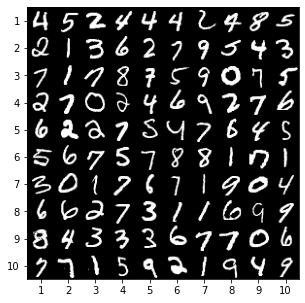

In [ ]:
plot_sample(vae)

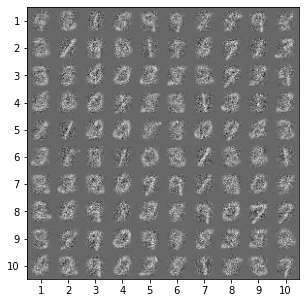

In [ ]:
plot_sample(vae, sample=True)

The digits appear to be realistic but are noisy versions of the actual samples. This may suggest that there is uncertainty in the exact shapes and the function is just learning the average of each digit. As a side note, learning just a single scale parameter performed much better than a diagonal or full covariance matrix.

### Problem 3b: Visualize the manifold of digits
Since we have specifically chosen the latent space to be 2-dimensional, now you can easily visualize the learned latent manifold of digits:
- Using your pre-trained recognition networks, transform images from the test set to the latent space. Visualize the points in the latent space as a scatter plot, where colors of the points should correspond to the labels of the digits.
- From the previous point, determine the min and max values of $z_1$ and $z_2$. Create a $20 \times 20$ grid that corresponds to $(z_1, z_2)$ values between the min and max. For each $z = (z_1, z_2)$, generate and visualize digits using each of your trained models, and plot each set on a $20 \times 20$ tile grid.

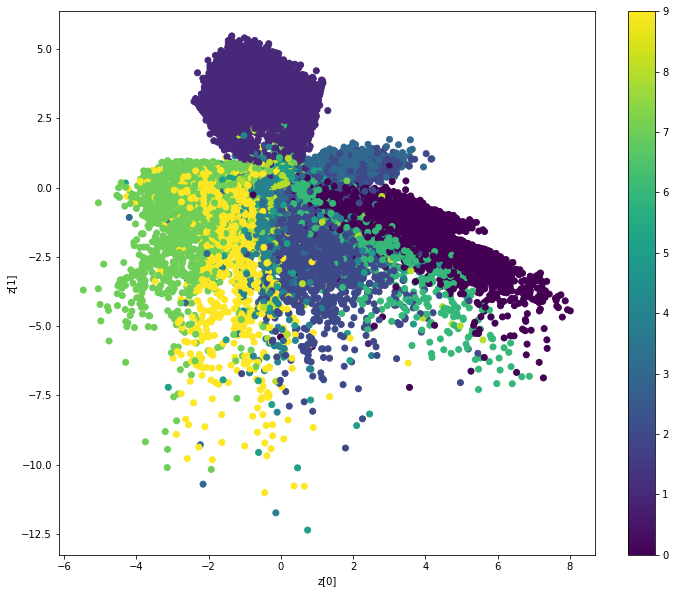

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_test, y_test), _ = keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_label_clusters(vae, x_test, y_test)

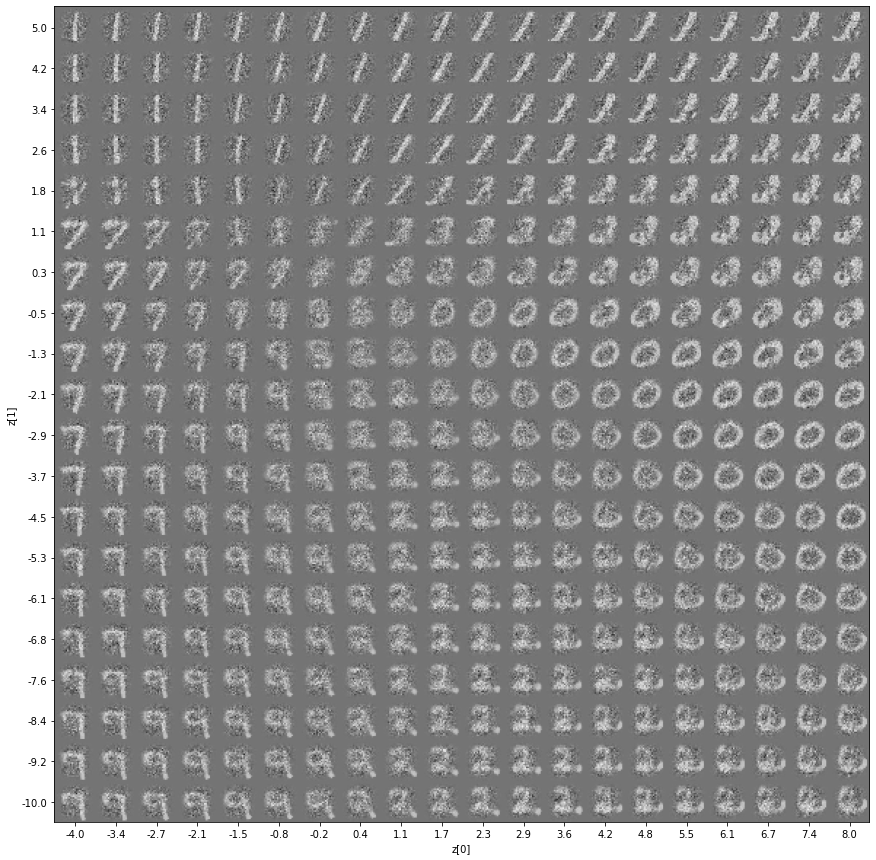

In [ ]:
def plot_grid(vae, z_0=8, z_1=15, n=20, figsize=15):
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  grid_x = np.linspace(-4, 8, n)
  grid_y = np.linspace(-10, 5, n)[::-1]

  for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

plot_grid(vae)

\pagebreak

## Problem 4: Discussion

### Problem 4a: Laplace prior on the latents
Suppose we instead used a [Laplace prior](https://en.wikipedia.org/wiki/Laplace_distribution) $z_n \sim \mathrm{Lap}(0, \tau)$ with density
\begin{align}
p(z_n) &= \frac{1}{2\tau}\exp \left\{-\frac{|z_n|}{\tau} \right\}.
\end{align}
Propose a simple reparametrization of the Laplace distribution $z_n = r(\epsilon_n, \tau)$ with $\epsilon_n \sim p(\epsilon)$ for some function $r$ and distribution $p$, suitable for training a VAE.

Letting $z_i \sim \mathrm{Lap}(0, \tau)$, then given a random variable $U\sim \mathrm{Unif}(-\frac{1}{2}, \frac{1}{2})$ gives:
\begin{gather*}
\mu - b\mathrm{sgn}(U)\ln (1 - 2|U|) \sim \mathrm{Lap}(\mu, b)
\end{gather*}
According to wikipedia. Thus, 
$$z_i \stackrel{\mathcal D}{=} -\tau\mathrm{\epsilon_n}\ln(1 - 2|\epsilon_n|) = r(\epsilon_n, \tau), \epsilon_n\sim\mathrm{Unif}(-\frac{1}{2}, \frac{1}{2})$$
Is a reparameterization of the laplace distribution suitable for training a VAE using the properties of this location-scale distribution (similar to Normal).

### Problem 4b: Discrete latent variables
The present model uses continuous latent variables. Where did we use this assumption and what would have to change if we used discrete $z_n$'s instead?

The place where we used the continuous latent variables assumption is in the reparameterization trick where we express a sampling step with a continuous differentiable function. This allows us to take gradients and learn parameters across the encoder and decoder. If we were to use discrete $z_n$'s instead, we would need to reparameterize in such a way that we can still differentiate from the loss function to the parameters (which is an active area of research).

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw6_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
